## Setup ( If run on non-colab environment)
Begin by installing and importing some necessary libraries

In [1]:
!pip install opencv-python
!pip install tensorflow
!pip install imageio
!pip install mlxtend

## Import library
Import all library which will be used later

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import cv2 # process video files
import imageio
import tensorflow as tf
import math
from google.colab import drive

Check exisitng GPU device

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


## Set Random Seed
Set random seed to ensure the result reproducibility

In [4]:
def reset_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)
    tf.config.experimental.enable_op_determinism()

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Access Dataset

In [5]:
# folder path that you store the video file and csv file
drive.mount('/content/drive')
dataset_file_path = "/content/drive/My Drive/"

dataset_filepath = dataset_file_path+"final_exam/input_data.csv"
df = pd.read_csv(dataset_filepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def convert_time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df["start_time_seconds"]=df["Start_Time"].apply(convert_time_to_seconds)
df["end_time_seconds"]=df["End_Time"].apply(convert_time_to_seconds)
class_list = df.Movement_Name.unique()

In [7]:
video_list = df.File_Path.unique()
video_list

array(['final_exam/input/2.mp4', 'final_exam/input/3.mp4',
       'final_exam/input/4.mp4', 'final_exam/input/5.mp4',
       'final_exam/input/8.mp4', 'final_exam/input/10.mp4',
       'final_exam/input/13.mp4', 'final_exam/input/14.mp4',
       'final_exam/input/15.mp4', 'final_exam/input/16.mp4',
       'final_exam/input/18.mp4', 'final_exam/input/19.mp4',
       'final_exam/input/20.mp4', 'final_exam/input/21.mp4',
       'final_exam/input/22.mp4', 'final_exam/input/24.mp4',
       'final_exam/input/25.mp4', 'final_exam/input/26.mp4',
       'final_exam/input/27.mp4', 'final_exam/input/28.mp4',
       'final_exam/input/29.mp4', 'final_exam/input/30.mp4',
       'final_exam/input/31.mp4', 'final_exam/input/32.mp4',
       'final_exam/input/33.mp4', 'final_exam/input/34.mp4',
       'final_exam/input/35.mp4'], dtype=object)

## Video Dataset Split
Split video into train, validation and test dataset

In [8]:
import random

# Set a specific seed value (for example, 42)
random.seed(42)

train_split_ratio = 0.7

random.shuffle(video_list)

split_idx = int(len(video_list) * train_split_ratio)

# Split data into train and test sets
train_videos_list_init = video_list[:split_idx]
test_videos_list = video_list[split_idx:]


train_validate_ratio = 0.75
random.shuffle(train_videos_list_init)

split_idx = int(len(train_videos_list_init) * train_validate_ratio)

train_videos_list= train_videos_list_init[:split_idx]
validate_videos_list = train_videos_list_init[split_idx:]

In [9]:
train_videos_list

array(['final_exam/input/33.mp4', 'final_exam/input/26.mp4',
       'final_exam/input/18.mp4', 'final_exam/input/19.mp4',
       'final_exam/input/22.mp4', 'final_exam/input/31.mp4',
       'final_exam/input/4.mp4', 'final_exam/input/20.mp4',
       'final_exam/input/3.mp4', 'final_exam/input/35.mp4',
       'final_exam/input/16.mp4', 'final_exam/input/28.mp4',
       'final_exam/input/21.mp4'], dtype=object)

In [10]:
validate_videos_list

array(['final_exam/input/10.mp4', 'final_exam/input/27.mp4',
       'final_exam/input/13.mp4', 'final_exam/input/25.mp4',
       'final_exam/input/24.mp4'], dtype=object)

In [11]:
test_videos_list

array(['final_exam/input/34.mp4', 'final_exam/input/8.mp4',
       'final_exam/input/30.mp4', 'final_exam/input/14.mp4',
       'final_exam/input/15.mp4', 'final_exam/input/32.mp4',
       'final_exam/input/2.mp4', 'final_exam/input/5.mp4',
       'final_exam/input/29.mp4'], dtype=object)

## Extract Frame
Extract frame and video preprocessing process (frame skipping, frame resize, frame color code conversion, color code normalization)

In [12]:
#Extract frame from video
def extract_frame(path,start_time,end_time):
  frame_list = []
  SEQUENCE_LENGTH = 24

  # Open the video file for reading
  video_reader = cv2.VideoCapture(path)

  # Get the frames per second (fps), start_frame, and end_frame for the specified video duration
  fps = int(video_reader.get(cv2.CAP_PROP_FPS))
  frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  start_frame = int(start_time*fps)
  end_frame = int(end_time*fps)
  interval_frame = end_frame - start_frame

  #calculate the skip frame number formula total duration of interval frame / sequence length
  skip_frame_window = max(interval_frame/SEQUENCE_LENGTH,1)

  # Get the height and width of the video frames
  height = video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = video_reader.get(cv2.CAP_PROP_FRAME_WIDTH)
  print(f'fps:{fps}, frame_cnt:{frame_count} interval_frame:{interval_frame}, height:{height}, width:{width}, start_frame:{start_frame},end_frame:{end_frame},skip:{skip_frame_window}')


  # Set the video reader to the start frame
  video_reader.set(cv2.CAP_PROP_POS_FRAMES,start_frame)
  current_frame = start_frame

  # Iterate through frames in the specified interval
  while video_reader.isOpened() and math.ceil(current_frame) < end_frame:
    ret, frame = video_reader.read()
    if not ret:
      break

    # Convert the frame from BGR to RGB
    frame_rgb_opencv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize the frame to a specific size (720x1280)
    resized_frame = cv2.resize(frame_rgb_opencv,(150,150))

    #normalize data to [0,1]
    frame = tf.image.convert_image_dtype(resized_frame, tf.float32)

    #brightness_increase = 70/255
    #brightened_frame = np.where((1 - frame) < brightness_increase, 1, frame + brightness_increase)

    # Append the resized frame to the frame_list
    frame_list.append(frame)

    # Set the video reader to the next frame position
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(current_frame + skip_frame_window) )

    # Increment the current_frame by skip_frame_window
    current_frame += skip_frame_window


  # Release the video reader and close any remaining OpenCV windows
  video_reader.release()
  cv2.destroyAllWindows()

  # Return the list of extracted frames
  return frame_list;

Extract frame and store in X_train, X_validate, X_Test. And store the relative label in Y_train, Y_validate, Y_Test.

In [13]:
reset_seed(42)

from tensorflow.keras.utils import to_categorical

X_train = [] #Save the frame
Y_train = [] #Save the label
X_validate = [] #Save the frame
Y_validate = [] #Save the label
X_test = [] #Save the frame
Y_test = [] #Save the label

for index,row in df.iterrows():
    start_time = row["start_time_seconds"]
    end_time = row["end_time_seconds"]
    path = dataset_file_path + row["File_Path"] # Get the vidoe file path
    label = row["Movement_Name"] # Get the Movement lable
    video_path = row["File_Path"]

    if video_path in train_videos_list:
        Y_train.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_train.append(np.asarray(frame_list))
    elif video_path in validate_videos_list:
        Y_validate.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_validate.append(np.asarray(frame_list))
    else:
        Y_test.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_test.append(np.asarray(frame_list))

#encode the label by using one-hot encoded
one_hot_encoded_labels_train = to_categorical(Y_train)
Y_train = one_hot_encoded_labels_train

one_hot_encoded_labels_validate = to_categorical(Y_validate)
Y_validate = one_hot_encoded_labels_validate

one_hot_encoded_labels_test = to_categorical(Y_test)
Y_test = one_hot_encoded_labels_test


fps:30, frame_cnt:1538 interval_frame:150, height:360.0, width:204.0, start_frame:330,end_frame:480,skip:6.25
fps:30, frame_cnt:1538 interval_frame:120, height:360.0, width:204.0, start_frame:570,end_frame:690,skip:5.0
fps:30, frame_cnt:1538 interval_frame:150, height:360.0, width:204.0, start_frame:840,end_frame:990,skip:6.25
fps:15, frame_cnt:931 interval_frame:75, height:480.0, width:640.0, start_frame:330,end_frame:405,skip:3.125
fps:30, frame_cnt:5991 interval_frame:210, height:720.0, width:1280.0, start_frame:1950,end_frame:2160,skip:8.75
fps:30, frame_cnt:5991 interval_frame:240, height:720.0, width:1280.0, start_frame:3960,end_frame:4200,skip:10.0
fps:15, frame_cnt:526 interval_frame:180, height:720.0, width:1280.0, start_frame:30,end_frame:210,skip:7.5
fps:23, frame_cnt:6078 interval_frame:69, height:240.0, width:320.0, start_frame:414,end_frame:483,skip:2.875
fps:23, frame_cnt:6078 interval_frame:92, height:240.0, width:320.0, start_frame:1081,end_frame:1173,skip:3.8333333333

## Training Data Augmentation
Augmentation techniques include rotate, flipping, grayscale and color inverted.

### Flipping

In [14]:
def data_augmentation_flip_bright(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            flipped_frame = cv2.flip(frame,1)

            brightness_increase = 75/255
            brightened_frame = np.where((1 - flipped_frame) < brightness_increase, 1, flipped_frame + brightness_increase)

            frame_list_aug.append(flipped_frame)
        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)

    return X_train_aug,Y_train_aug

### Rotate

In [15]:
def data_augmentation_rotate_contrast(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            # Define the rotation angle (in degrees)
            angle = 180  # Example rotation angle

            # Get image dimensions for rotation
            height, width = frame.shape[:2]

            # Calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

            # Perform the rotation
            rotated_frame = cv2.warpAffine(frame, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)


            alpha = 1.5  # Contrast control (1.0 means no change)
            adjusted_frame = cv2.multiply(rotated_frame, np.array([alpha]))

            frame_list_aug.append(adjusted_frame)
        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)

    return X_train_aug,Y_train_aug

### Grayscale

In [16]:
def data_augmentation_grayscale(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            gray_img = cv2.cvtColor((frame * 255).astype(np.uint8),cv2.COLOR_RGB2GRAY)
            normalized_frame = gray_img / 255.0

             # Expand dimensions to match the required channel size (e.g., 3 for RGB)
            expanded_frame = np.expand_dims(normalized_frame, axis=-1)  # Add a channel dimension

            # Duplicate the grayscale channel to match the number of channels in the original RGB frames
            stacked_frame = np.concatenate([expanded_frame] * 3, axis=-1)  # Repeat grayscale channel 3 times

            frame_list_aug.append(stacked_frame)

        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)

    return X_train_aug,Y_train_aug

### Color Inverted

In [17]:
def data_augmentation_inverted(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            invert_img =  cv2.bitwise_not((frame * 255).astype(np.uint8))
            normalized_frame = invert_img / 255.0

            frame_list_aug.append(normalized_frame)

        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)

    return X_train_aug,Y_train_aug

Data augmentation and combine with existing training data

In [18]:
X_train_aug_1,Y_train_aug_1 = data_augmentation_flip_bright(X_train,Y_train)
X_train_aug_2,Y_train_aug_2 = data_augmentation_rotate_contrast(X_train,Y_train)
X_train_aug_3,Y_train_aug_3 = data_augmentation_grayscale(X_train,Y_train)

X_train_aug_1 = np.array([np.array(frame_list) for frame_list in X_train_aug_1])
X_train_aug_2 = np.array([np.array(frame_list) for frame_list in X_train_aug_2])
X_train_aug_3 = np.array([np.array(frame_list) for frame_list in X_train_aug_3])

X_train = np.append(X_train, X_train_aug_1, axis=0)
Y_train = np.append(Y_train, Y_train_aug_1, axis=0)
X_train = np.append(X_train, X_train_aug_2, axis=0)
Y_train = np.append(Y_train, Y_train_aug_2, axis=0)
X_train = np.append(X_train, X_train_aug_3, axis=0)
Y_train = np.append(Y_train, Y_train_aug_3, axis=0)

## Data augmentation visualisation

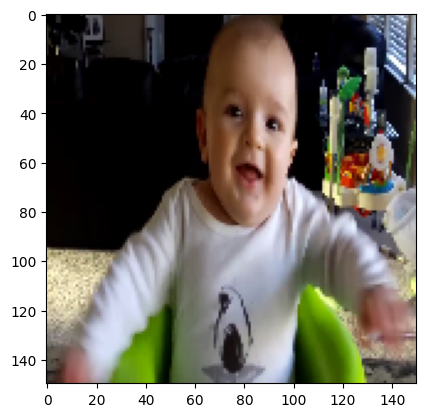

In [19]:
ori_images = np.clip(X_train[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(ori_images)

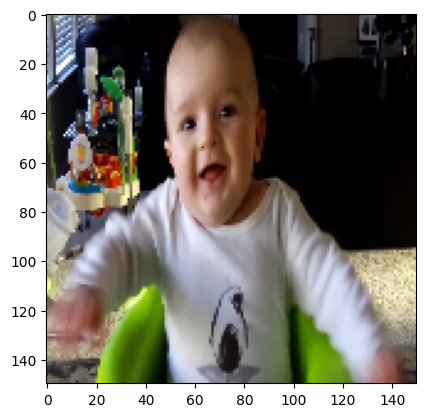

In [20]:
flip_images = np.clip(X_train_aug_1[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(flip_images)

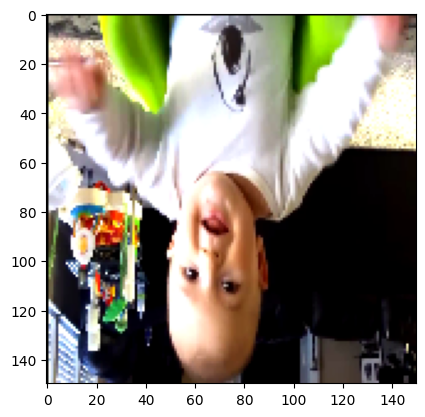

In [21]:
rotate_images = np.clip(X_train_aug_2[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(rotate_images)

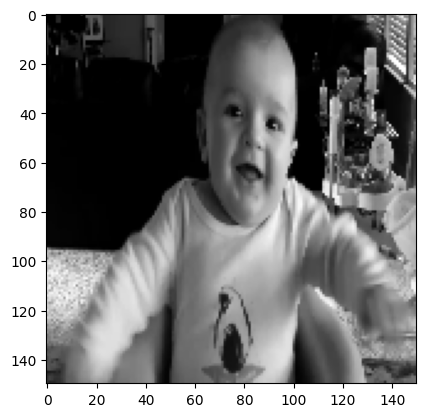

In [22]:
gray_images = np.clip(X_train_aug_3[2][1]*255, 0, 255).astype(np.uint8)
plt.imshow(gray_images)

# Construct Model - Using tensorflow Convlstm2d
To avoid the overfitting issue, the model will apply dropout, regularization and batch normalization technique


In [23]:
reset_seed(42)

import torchvision.models as models
import keras.models as kmodels
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import tanh

def create_convlstm_model():
    l2_reg=0.01
  #kernel_regularizer=l2(l2_reg),
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=4, activation='tanh', kernel_regularizer=l2(l2_reg),
                        recurrent_dropout=0.4,
                        data_format = "channels_last", return_sequences=True, input_shape=(24,150,150,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(ConvLSTM2D(filters=8, kernel_size=4, activation='tanh', kernel_regularizer=l2(l2_reg),
                        recurrent_dropout=0.4,
                         data_format = "channels_last", return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(ConvLSTM2D(filters=14, kernel_size=4, activation='tanh',kernel_regularizer=l2(l2_reg),
                         recurrent_dropout=0.4,
                         data_format = "channels_last", return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(ConvLSTM2D(filters=16, kernel_size=4, activation='tanh',kernel_regularizer=l2(l2_reg),
                         recurrent_dropout=0.4,
                         data_format = "channels_last", return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))


    model.add(Flatten())
    model.add(Dense(units=class_list.size, activation='softmax'))

    model.summary()

    return model

## Model training
To avoid overfitting issue, early stopping and reduce LR technique will be utilised.

In [24]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

learning_rate = 0.0001

from tensorflow.keras.optimizers import Adam

reset_seed(42)

convlstm_model = create_convlstm_model()
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5,factor=0.2)

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

convlstm_model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

X_train_tensor = tf.convert_to_tensor(X_train)
X_validate_tensor = tf.convert_to_tensor(X_validate)

convlstm_model_training_history = convlstm_model.fit(x=X_train_tensor,y = Y_train,epochs = 50, batch_size=16 ,shuffle=True,
                                                     validation_data = (X_validate_tensor, Y_validate), callbacks=[early_stopping_callback,reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 24, 147, 147, 4)   1808      
                                                                 
 batch_normalization (Batch  (None, 24, 147, 147, 4)   16        
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 24, 74, 74, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 24, 74, 74, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 24, 71, 71, 8)     6176      
                                                        

## Model Evaluation

In [25]:
X_test_tensor = tf.convert_to_tensor(X_test)
model_evaluation_history = convlstm_model.evaluate(X_test_tensor,Y_test)

1/1 [==============================] - 1s 792ms/step - loss: 1.1694 - accuracy: 0.7143


1/1 [==============================] - 1s 1s/step


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

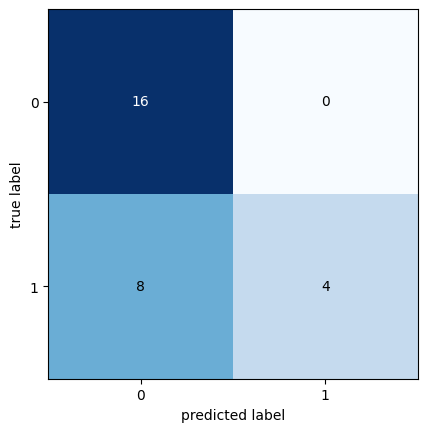

In [26]:
y_pred = convlstm_model.predict(X_test_tensor)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)
y_pred_reversed = np.argmax(y_pred_classes, axis=1)
y_test_reversed = np.argmax(Y_test, axis=1)

mat = confusion_matrix(y_test_reversed,y_pred_reversed)
plot_confusion_matrix(conf_mat = mat)

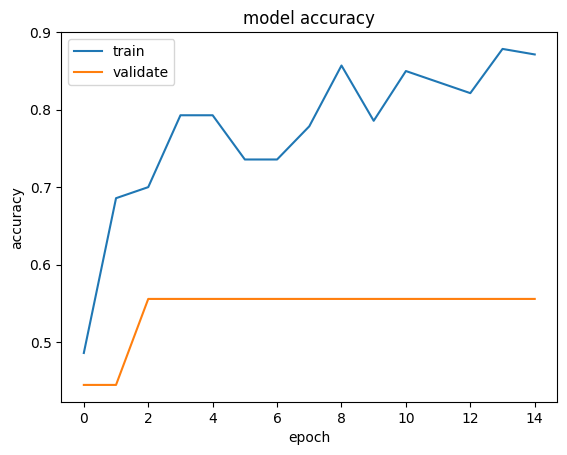

In [27]:
# summarize history for accuracy
plt.plot(convlstm_model_training_history.history['accuracy'])
plt.plot(convlstm_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

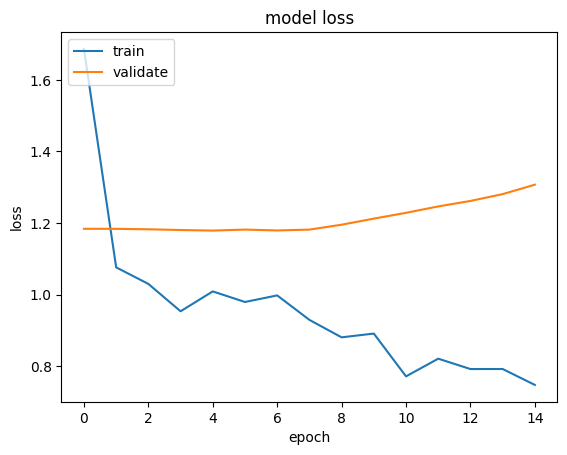

In [28]:
# summarize history for loss
plt.plot(convlstm_model_training_history.history['loss'])
plt.plot(convlstm_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()